Self attention mecanismo de atencion que utiliza los transformers
Este mecanismo de atención consiste en tres conjuntos de vectores K, Q y V, llamados respectivamente keys, queries y values. Utilizaremos K y Q para calcular la matriz de atención, la cual aplicaremos a V.
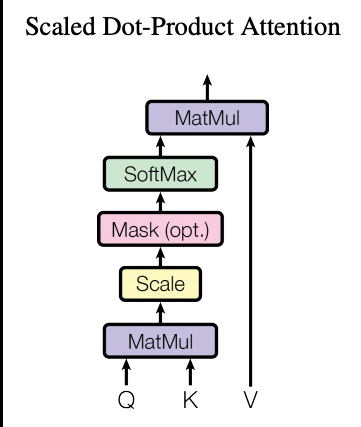


In [3]:
!pip install torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2

     |████████████████████████████████| 7.0MB 7.3MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 819kB 70kB/s 
     |████████████████████████████████| 829kB 46.8MB/s 
     |████████████████████████████████| 276kB 51.9MB/s 
     |████████████████████████████████| 122kB 53.3MB/s 
     |████████████████████████████████| 1.3MB 43.7MB/s 
     |████████████████████████████████| 143kB 52.9MB/s 
     |████████████████████████████████| 296kB 38.2MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=1116e4dbdfcf5b90d9180b7afa069d7fb26e2a36c59dd4c5bc834ef5df7686d7
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44636 sha256=a9abac3757d6819eb9f4bc0efbf2b69ed6f8a27733c85377bbc9084678f10d94
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3

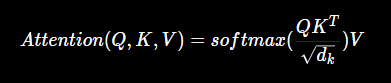
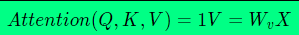
```





In [4]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader

In [5]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return torch.tensor(self.X[ix]).float(), torch.tensor(self.y[ix]).long()

class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 64, Dataset = Dataset):
        super().__init__()
        self.batch_size = batch_size
        self.Dataset = Dataset

    def setup(self, stage=None):
        mnist = fetch_openml('mnist_784', version=1)
        X, y = mnist["data"], mnist["target"]
        X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., y[:60000].astype(np.int), y[60000:].astype(np.int)
        self.train_ds = self.Dataset(X_train, y_train)
        self.val_ds = self.Dataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [6]:
dm = MNISTDataModule()
dm.setup()
imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 784]), torch.Size([64]))

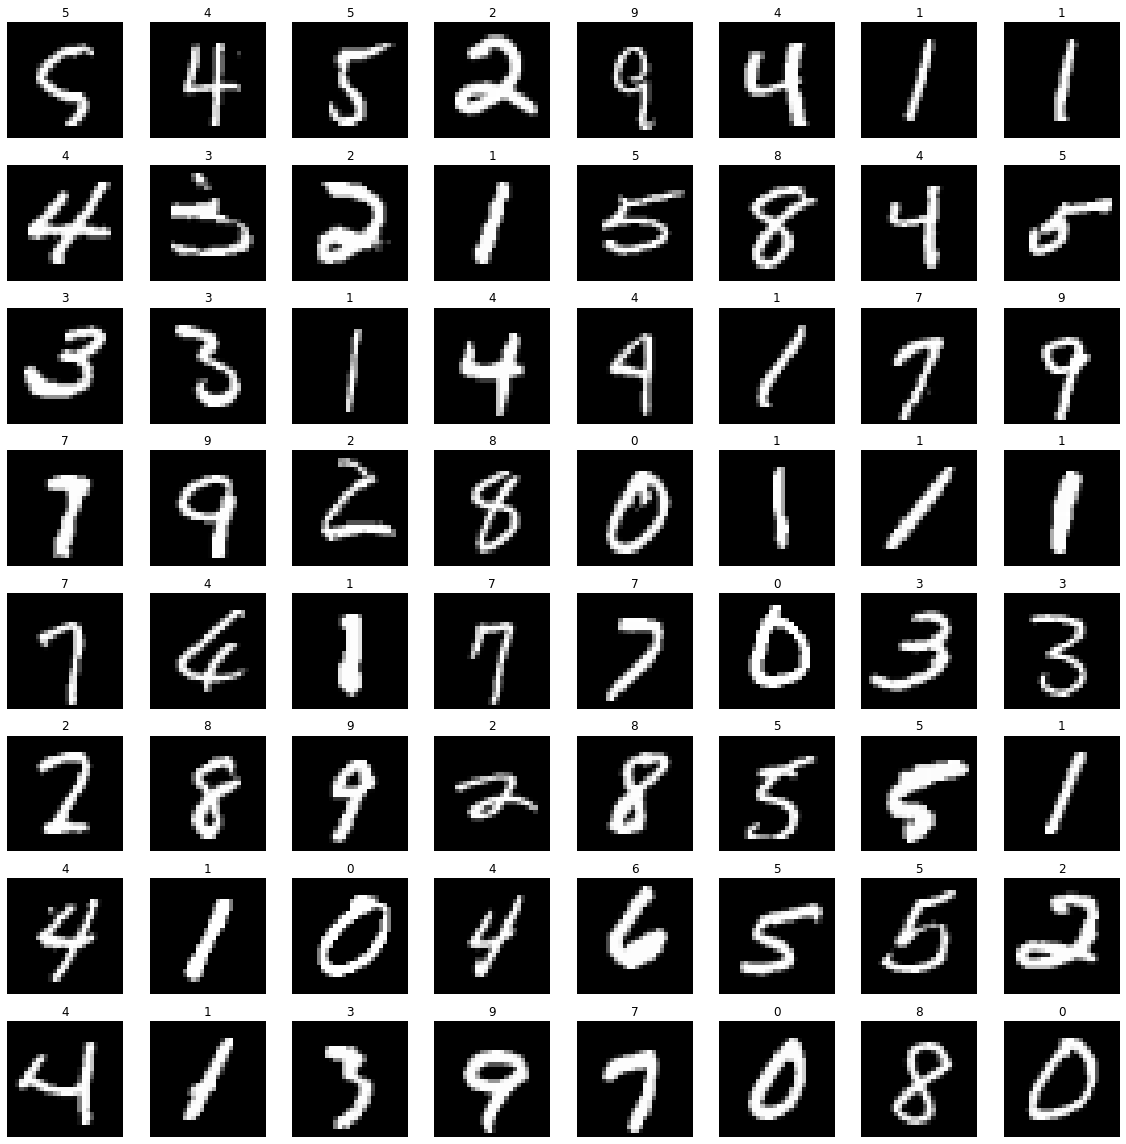

In [7]:
r, c = 8, 8
fig = plt.figure(figsize=(c*2, r*2))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(28,28), cmap="gray")
        ax.set_title(label.item())
plt.tight_layout()
plt.show()


In [8]:
class MLP(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(784, 784),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(784, 10)
        )

    def forward(self, x):
        return self.mlp(x)

    def predict(self, x):
        with torch.no_grad():
          y_hat = self(x)
          return torch.argmax(y_hat, axis=1)

    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.003)
        return optimizer

In [9]:
mlp = MLP()
outuput = mlp(torch.randn(64, 784))
outuput.shape

torch.Size([64, 10])

In [10]:
mlp = MLP()
trainer = pl.Trainer(max_epochs=5)
trainer.fit(mlp, dm)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 623 K 
------------------------------------
623 K     Trainable params
0         Non-trainable params
623 K     Total params
2.493     Total estimated model params size (MB)


1

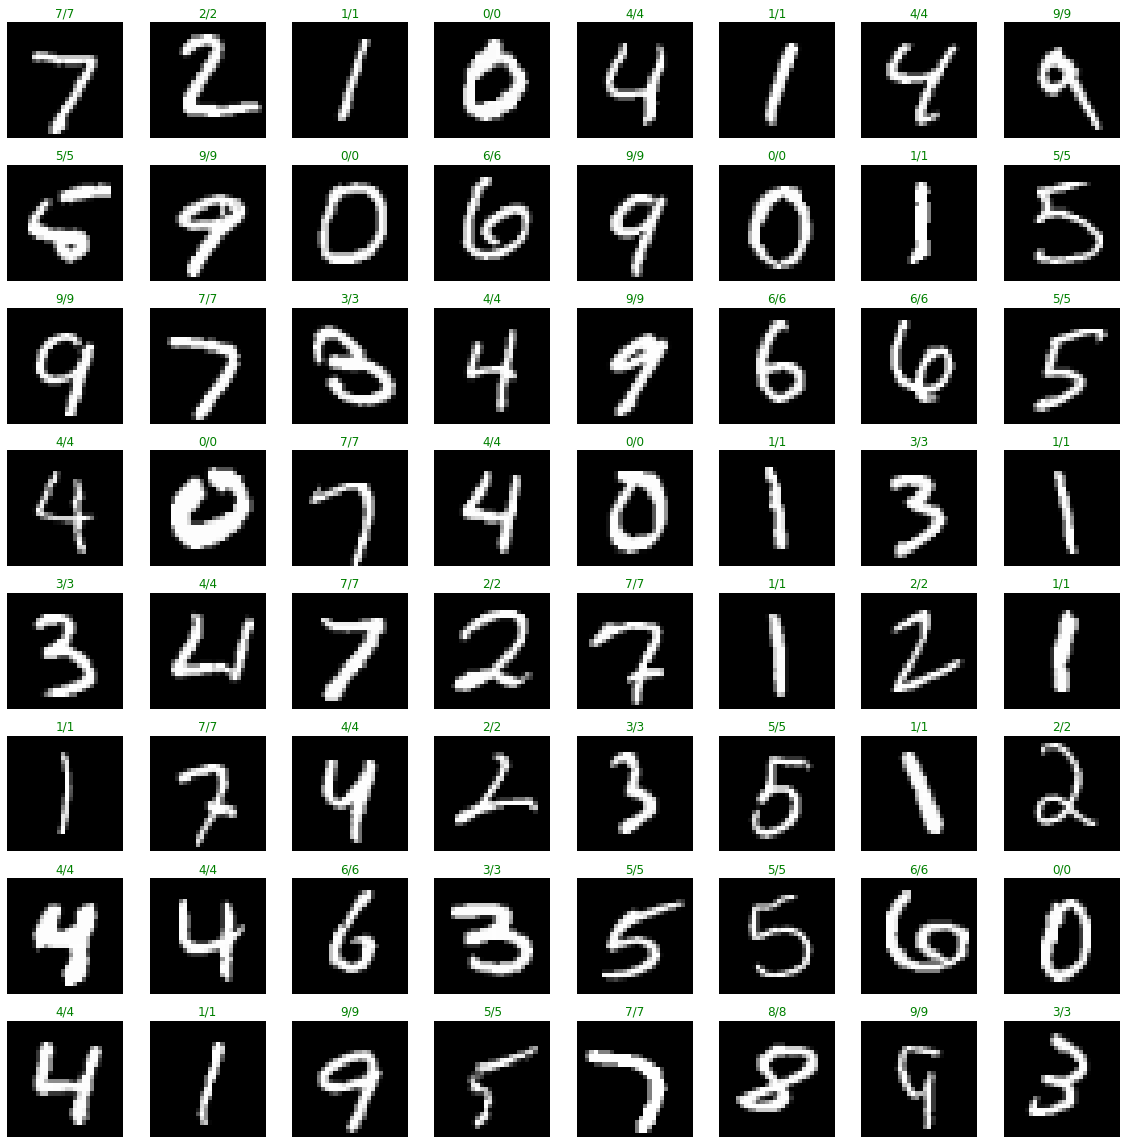

In [11]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = mlp.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(c*2, r*2))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(28,28), cmap="gray")
        ax.set_title(f'{label.item()}/{preds[ix].item()}', color="green" if label == preds[ix] else 'red')
plt.tight_layout()
plt.show()

Resolvemos con mecanismos de attention

In [12]:
class AttnDataset(torch.utils.data.Dataset):
  def __init__(self, X, y, patch_size=(7, 7)):
    self.X = X
    self.y = y
    self.patch_size = patch_size

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    image = torch.tensor(self.X[ix]).float().view(28, 28) # 28 x 28
    h, w = self.patch_size
    patches = image.unfold(0, h, h).unfold(1, w, w) # 4 x 4 x 7 x 7
    patches = patches.contiguous().view(-1, h*w) # 16 x 49
    return patches, torch.tensor(self.y[ix]).long()

Resolvemos el mismo ejercicio con Mecanismos de atencion

In [13]:
#nuestro data set
class AttnDataset(torch.utils.data.Dataset):
  def __init__(self, X, y, patch_size=(7, 7)):
    self.X = X
    self.y = y
    self.patch_size = patch_size

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    image = torch.tensor(self.X[ix]).float().view(28, 28) # 28 x 28
    h, w = self.patch_size
    patches = image.unfold(0, h, h).unfold(1, w, w) # 4 x 4 x 7 x 7
    patches = patches.contiguous().view(-1, h*w) # 16 x 49
    return patches, torch.tensor(self.y[ix]).long()

In [14]:
attn_dm = MNISTDataModule(Dataset = AttnDataset)
attn_dm.setup()
imgs, labels = next(iter(attn_dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 16, 49]), torch.Size([64]))

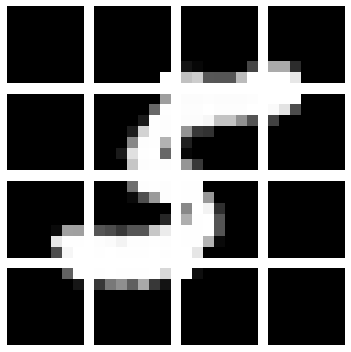

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax = plt.subplot(4, 4, i*4 + j + 1)
        ax.imshow(imgs[6,i*4 + j].view(7, 7), cmap="gray")
        ax.axis('off')
plt.tight_layout()
plt.show()

In [16]:
#modelo Selfatencion
#aplicaremos el mecanismo de atención básico utilizado en los Transformers, el scaled dot-product attention.
import math

class ScaledDotSelfAttention(torch.nn.Module):

    def __init__(self, n_embd):
        super().__init__()

        # key, query, value projections
        self.key = torch.nn.Linear(n_embd, n_embd)
        self.query = torch.nn.Linear(n_embd, n_embd)
        self.value = torch.nn.Linear(n_embd, n_embd)

    def forward(self, x):
        B, L, F = x.size()

        # calculate query, key, values
        k = self.key(x) # (B, L, F)
        q = self.query(x) # (B, L, F)
        v = self.value(x) # (B, L, F)

        # attention (B, L, F) x (B, F, L) -> (B, L, L)
        att = (q @ k.transpose(1, 2)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, L, L) x (B, L, F) -> (B, L, F)

        return y

class Model(MLP):

    def __init__(self, n_embd=7*7, seq_len=4*4):
        super().__init__()
        self.mlp = None

        self.attn = ScaledDotSelfAttention(n_embd)
        self.actn = torch.nn.ReLU(inplace=True)
        self.fc = torch.nn.Linear(n_embd*seq_len, 10)

    def forward(self, x):
        x = self.attn(x)
        #print(x.shape)
        y = self.fc(self.actn(x.view(x.size(0), -1)))
        #print(y.shape)
        return y

In [17]:
model = Model()
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model, attn_dm)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name | Type                   | Params
------------------------------------------------
0 | attn | ScaledDotSelfAttention | 7.4 K 
1 | actn | ReLU                   | 0     
2 | fc   | Linear                 | 7.9 K 
------------------------------------------------
15.2 K    Trainable params
0         Non-trainable params
15.2 K    Total params
0.061     Total estimated model params size (MB)


1

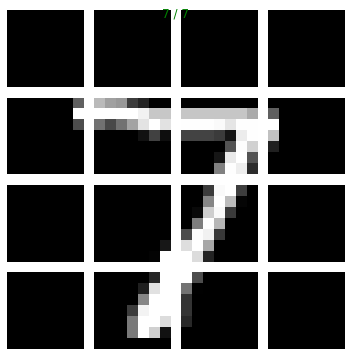

In [18]:
#prediccion
import random

attn_imgs, attn_labels = next(iter(attn_dm.val_dataloader()))
preds = model.predict(attn_imgs)

ix = random.randint(0, dm.batch_size)
fig = plt.figure(figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax = plt.subplot(4, 4, i*4 + j + 1)
        ax.imshow(attn_imgs[ix,i*4 + j].view(7, 7), cmap="gray")
        ax.axis('off')
fig.suptitle(f'{attn_labels[ix]} / {preds[ix].item()}', color="green" if attn_labels[ix] == preds[ix].item() else "red")
plt.tight_layout()
plt.show()

MEcanismo MultiheadAttention
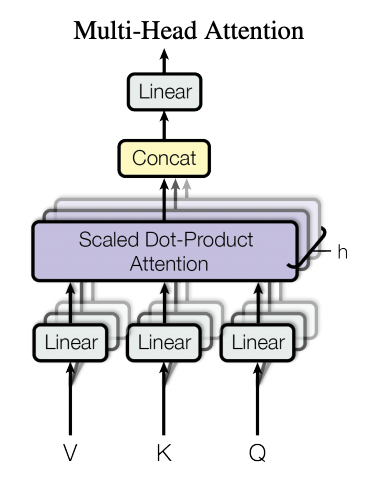

Este mecanismo toma inspiración en el uso de múltiples filtros en una red convolucional para mejorar la capacidad de representación de datos. En el contexto de atención, esto se traduce en repetir un número determinado de veces (heads o cabezas) el mecanismo de scaled-dot product attention que conocemos del post anterior.
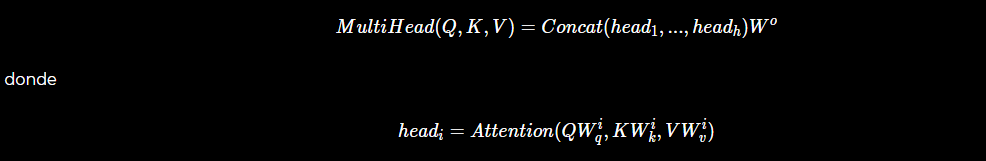

A grandes rasgos, repetimos el mecanismo de atención aplicando diferentes proyecciones a la hora de obtener nuestras queries, keys y values. Una vez aplicada la atención a cada cabeza, concatenamos los resultados y aplicamos una nueva capa lineal para obtener el resultado final.


In [19]:
mlp = MLP()
outuput = mlp(torch.randn(64, 784))
outuput.shape

torch.Size([64, 10])

In [20]:
mlp = MLP()
trainer = pl.Trainer(max_epochs=5)
trainer.fit(mlp, dm)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 623 K 
------------------------------------
623 K     Trainable params
0         Non-trainable params
623 K     Total params
2.493     Total estimated model params size (MB)


1

In [21]:
import math

class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads

        # key, query, value projections
        self.key = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.query = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.value = torch.nn.Linear(n_embd, n_embd*n_heads)

        # output projection
        self.proj = torch.nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)

        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # re-assemble all head outputs side by side

        return self.proj(y)

class Model(MLP):

    def __init__(self, n_embd=7*7, seq_len=4*4, n_heads=4*4):
        super().__init__()
        self.mlp = None

        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.actn = torch.nn.ReLU(inplace=True)
        self.fc = torch.nn.Linear(n_embd*seq_len, 10)

    def forward(self, x):
        x = self.attn(x)
        #print(x.shape)
        y = self.fc(self.actn(x.view(x.size(0), -1)))
        #print(y.shape)
        return y

In [22]:
model = Model()
trainer = pl.Trainer(max_epochs=5, gpus=1)
trainer.fit(model, attn_dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name | Type               | Params
--------------------------------------------
0 | attn | MultiHeadAttention | 156 K 
1 | actn | ReLU               | 0     
2 | fc   | Linear             | 7.9 K 
--------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.656     Total estimated model params size (MB)


1

In [23]:
class AttnDataset(torch.utils.data.Dataset):
  def __init__(self, X, y, patch_size=(7, 7)):
    self.X = X
    self.y = y
    self.patch_size = patch_size

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    image = torch.tensor(self.X[ix]).float().view(28, 28) # 28 x 28
    h, w = self.patch_size
    patches = image.unfold(0, h, h).unfold(1, w, w) # 4 x 4 x 7 x 7
    patches = patches.contiguous().view(-1, h*w) # 16 x 49
    return patches, torch.tensor(self.y[ix]).long()
    

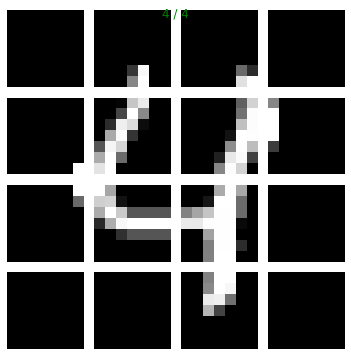

In [24]:
#prediccion
import random

attn_imgs, attn_labels = next(iter(attn_dm.val_dataloader()))
preds = model.predict(attn_imgs)

ix = random.randint(0, dm.batch_size)
fig = plt.figure(figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax = plt.subplot(4, 4, i*4 + j + 1)
        ax.imshow(attn_imgs[ix,i*4 + j].view(7, 7), cmap="gray")
        ax.axis('off')
fig.suptitle(f'{attn_labels[ix]} / {preds[ix].item()}', color="green" if attn_labels[ix] == preds[ix].item() else "red")
plt.tight_layout()
plt.show()